In [1]:
import numpy as np
import pandas as pd 
import copy

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"
from tensorflow import keras

import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import matplotlib.pyplot as plt

2024-07-25 17:17:53.463506: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-25 17:17:53.465522: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-25 17:17:53.492018: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 17:17:53.492060: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 17:17:53.492920: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
m_train = 40000
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train, x_valid = x_train_full[:m_train]/255.0,  x_train_full[m_train:]/255.0
y_train, y_valid = y_train_full[:m_train],  y_train_full[m_train:] 
x_test = x_test/255.0

In [3]:
# train set
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
# validation set 
print(f"x_valid shape: {x_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
# test set 
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (40000, 32, 32, 3)
y_train shape: (40000, 1)
x_valid shape: (10000, 32, 32, 3)
y_valid shape: (10000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


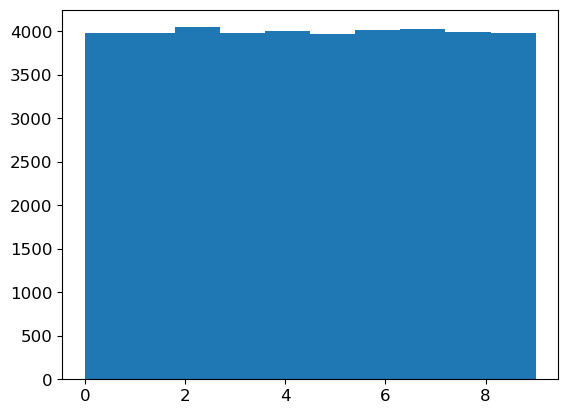

In [4]:
plt.hist(y_train)
plt.show()

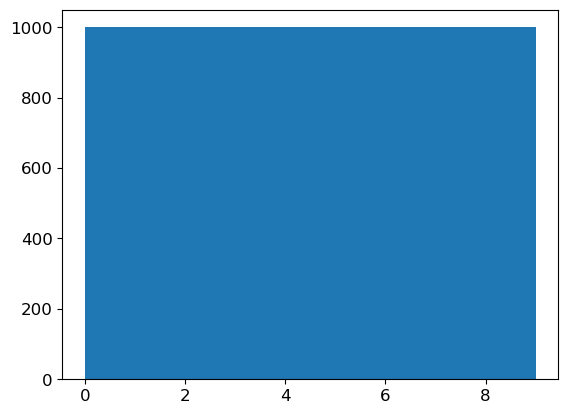

In [5]:
plt.hist(y_test)
plt.show()

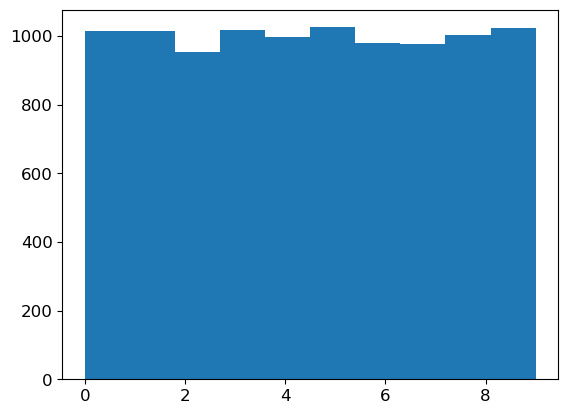

In [6]:
plt.hist(y_valid)
plt.show()

# A. 

## A.1. Finding an appropriate learning rate.

In [7]:
# init sequential model and first layer 
lr_finder_A = keras.models.Sequential(
    [
         # 0. input layer: A flatten layer with the shape 28*28. 
        keras.layers.Flatten(
            input_shape = [32, 32, 3],
            name = "flatten_input"
        ),
    ]
)
# Hidden layers
n_hidden_A = 20
for l in range(n_hidden_A):
    lr_finder_A.add(
        keras.layers.Dense(
            units = 100,
            activation = 'elu',
            kernel_initializer = keras.initializers.HeNormal( seed = 24 ), # could write "he_normal"
            name = "hidden_layer_"+str(l+1)
        )
    )
# We use 'softmax' activation function, to get probabilities. 
lr_finder_A.add(
    keras.layers.Dense(
        units = 10,
        activation = 'softmax',
        kernel_initializer = keras.initializers.HeNormal( seed = 24 ), # could write "he_normal"
        name = 'output' 
)
)
lr_finder_A.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_input (Flatten)     (None, 3072)              0         
                                                                 
 hidden_layer_1 (Dense)      (None, 100)               307300    
                                                                 
 hidden_layer_2 (Dense)      (None, 100)               10100     
                                                                 
 hidden_layer_3 (Dense)      (None, 100)               10100     
                                                                 
 hidden_layer_4 (Dense)      (None, 100)               10100     
                                                                 
 hidden_layer_5 (Dense)      (None, 100)               10100     
                                                                 
 hidden_layer_6 (Dense)      (None, 100)               1

In [8]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs):
        self.rates.append(
            K.get_value(self.model.optimizer.learning_rate)
        )
        self.losses.append(logs["loss"])
        K.set_value(
            self.model.optimizer.learning_rate, 
            self.model.optimizer.learning_rate * self.factor
        )

In [9]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

lr_finder_A.compile(
        # we could write loss = 'sparse_categorical_crossentropy'
        loss = keras.losses.SparseCategoricalCrossentropy(), 
        #
        # we could write optimizer = 'sgd'
        optimizer = keras.optimizers.SGD(
            learning_rate = float(1e-4),
            momentum = 0.9
        ),
        #
        #
        metrics = [keras.metrics.SparseCategoricalAccuracy()]
)
    # fit

expon_lr = ExponentialLearningRate(factor=1.005)

lr_finder_A.fit(
    x_train,
    y_train,
    epochs = 1,
    validation_data = (x_valid, y_valid),
    callbacks = [expon_lr]
)

1250/1250 [==============================] - 9s 7ms/step - loss: nan - sparse_categorical_accuracy: 0.1869 - val_loss: nan - val_sparse_categorical_accuracy: 0.1014


Text(0, 0.5, 'Loss')

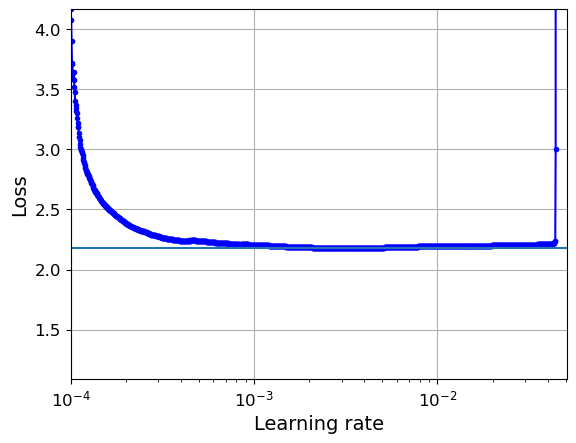

In [10]:
plt.plot(expon_lr.rates, expon_lr.losses, 'b.-')
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), max(0, min(expon_lr.losses)/2)  , expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [11]:
# returns the first point that we get a nan. 
np.argmax(np.isnan(np.array(expon_lr.losses)))

1223

In [12]:
min_loss_id = np.argmin(np.array(expon_lr.losses[:1223]))
expon_lr.rates[min_loss_id], min_loss_id, min(expon_lr.losses)

(0.002202709, 620, 2.1790354251861572)

Let's take it a bit less than that and use `lr=0.01` and train the model again. 

## A.2. Trainging the mode

In [16]:
model_A = keras.models.Sequential(
    [
         # 0. input layer: A flatten layer with the shape 28*28. 
        keras.layers.Flatten(
            input_shape = [32, 32, 3],
            name = "flatten_input"
        ),
    ]
)
# Hidden layers
n_hidden_A = 20
for l in range(n_hidden_A):
    model_A.add(
        keras.layers.Dense(
            units = 100,
            activation = 'elu',
            kernel_initializer = keras.initializers.HeNormal( seed = 24 ), # could write "he_normal"
            name = "hidden_layer_"+str(l+1)
        )
    )
# We use 'softmax' activation function, to get probabilities. 
model_A.add(
    keras.layers.Dense(
        units = 10,
        activation = 'softmax',
        kernel_initializer = keras.initializers.HeNormal( seed = 24 ), # could write "he_normal"
        name = 'output' 
    )
)
# Compile 
model_A.compile(
    # we could write loss = 'sparse_categorical_crossentropy'
    loss = keras.losses.SparseCategoricalCrossentropy(), 
    #
    # we could write optimizer = 'sgd'
    optimizer = keras.optimizers.SGD(
        learning_rate = float(1e-3),
        momentum = 0.9,
        nesterov = True
    ),
    #
    #
    metrics = [keras.metrics.SparseCategoricalAccuracy()]
)
# Fit 
model_A.fit(
    x_train,
    y_train,
    epochs = 100,
    validation_data = (x_valid, y_valid),
    callbacks = [
        keras.callbacks.EarlyStopping(
            patience = 20,
            restore_best_weights = True
        )
    ]
)

Epoch 1/100
1250/1250 [==============================] - 10s 7ms/step - loss: 1.9890 - sparse_categorical_accuracy: 0.2722 - val_loss: 1.8392 - val_sparse_categorical_accuracy: 0.3229
Epoch 2/100
1250/1250 [==============================] - 10s 8ms/step - loss: 1.7804 - sparse_categorical_accuracy: 0.3509 - val_loss: 1.7696 - val_sparse_categorical_accuracy: 0.3584
Epoch 3/100
1250/1250 [==============================] - 8s 7ms/step - loss: 1.6972 - sparse_categorical_accuracy: 0.3857 - val_loss: 1.6961 - val_sparse_categorical_accuracy: 0.3857
Epoch 4/100
1250/1250 [==============================] - 8s 6ms/step - loss: 1.6354 - sparse_categorical_accuracy: 0.4099 - val_loss: 1.6404 - val_sparse_categorical_accuracy: 0.4079
Epoch 5/100
1250/1250 [==============================] - 8s 7ms/step - loss: 1.5792 - sparse_categorical_accuracy: 0.4340 - val_loss: 1.6164 - val_sparse_categorical_accuracy: 0.4235
Epoch 6/100
1250/1250 [==============================] - 8s 6ms/step - loss: 1.5452

Text(0.5, 0, 'epoch')

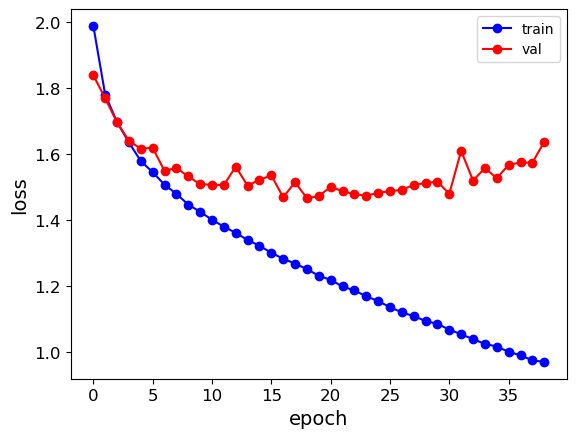

In [17]:
plt.plot(model_A.history.history['loss'], 'bo-', label = 'train')
plt.plot(model_A.history.history['val_loss'], 'ro-', label = 'val')
plt.legend()
#plt.title(f"lr = {histories_lr[str(row)]['lr']}")
plt.ylabel('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

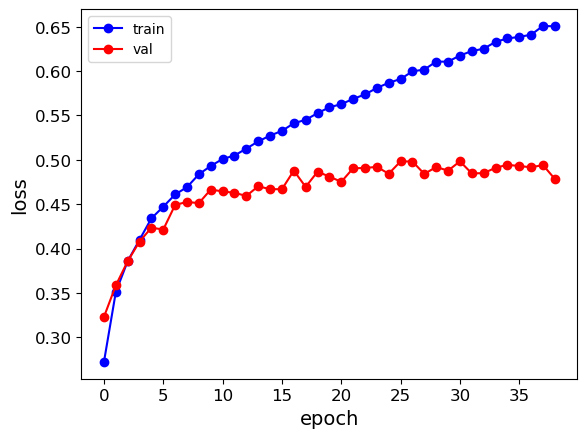

In [18]:
plt.plot(model_A.history.history['sparse_categorical_accuracy'], 'bo-', label = 'train')
plt.plot(model_A.history.history['val_sparse_categorical_accuracy'], 'ro-', label = 'val')
plt.legend()
#plt.title(f"lr = {histories_lr[str(row)]['lr']}")
plt.ylabel('loss')
plt.xlabel('epoch')